In [64]:
from typing import Callable, Dict, Iterable, Self
from numpy.typing import NDArray
import datasets
import tensorflow as tf
import numpy as np
import einops
import pandas as pd
import pickle
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import json

import flagon

# Solar Home Dataset

In [65]:
with open("data/solar_home_data.pkl", 'rb') as f:
    data = pickle.load(f)

with open("data/customer_regions.json", 'r') as f:
    customer_regions = json.load(f)

def get_customer_data(customer=1):
    idx = np.arange(24, len(data[customer]))
    expanded_idx = np.array([np.arange(i - 24, i - 1) for i in idx])
    return data[customer][expanded_idx], data[customer][idx, 0]

In [68]:
customer_regions

{'1': 1,
 '2': 3,
 '3': 3,
 '4': 3,
 '5': 3,
 '6': 3,
 '7': 3,
 '8': 1,
 '9': 3,
 '10': 3,
 '14': 3,
 '15': 3,
 '18': 1,
 '19': 3,
 '23': 3,
 '27': 1,
 '29': 3,
 '30': 3,
 '35': 4,
 '36': 2,
 '37': 3,
 '39': 3,
 '41': 4,
 '42': 3,
 '43': 3,
 '49': 3,
 '51': 4,
 '53': 1,
 '54': 3,
 '56': 3,
 '59': 4,
 '61': 3,
 '64': 3,
 '65': 1,
 '66': 3,
 '68': 4,
 '69': 3,
 '70': 3,
 '71': 3,
 '73': 4,
 '75': 3,
 '77': 4,
 '81': 1,
 '84': 3,
 '87': 4,
 '88': 4,
 '94': 1,
 '95': 1,
 '96': 0,
 '98': 3,
 '99': 0,
 '105': 1,
 '107': 4,
 '108': 4,
 '110': 4,
 '112': 1,
 '118': 3,
 '119': 4,
 '122': 4,
 '123': 1,
 '125': 4,
 '126': 3,
 '127': 3,
 '129': 0,
 '133': 4,
 '137': 3,
 '140': 3,
 '145': 3,
 '146': 4,
 '148': 4,
 '150': 2,
 '151': 4,
 '154': 1,
 '155': 3,
 '156': 3,
 '158': 3,
 '160': 3,
 '161': 1,
 '163': 4,
 '167': 3,
 '168': 3,
 '171': 3,
 '173': 3,
 '174': 1,
 '178': 3,
 '184': 3,
 '186': 3,
 '187': 0,
 '193': 3,
 '194': 3,
 '196': 3,
 '202': 3,
 '204': 1,
 '206': 3,
 '208': 1,
 '209': 1,
 '21

In [66]:
class Client(flagon.Client):
    def __init__(self, data, create_model_fn):
        self.data = data
        self.model = create_model_fn()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.data['train']['X'], self.data['train']['Y'], epochs=config['num_epochs'])
        return self.model.get_weights(), len(self.data['train']), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.data['test']['X'], self.data['test']['Y'])
        return len(self.data['test']), {'loss': loss, 'accuracy': accuracy}

In [67]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((23, 4))
    # x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Conv1D(64, 5, activation="relu")(inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(32, 2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="mean_squared_error",
        metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [74]:
def create_clients(create_model_fn, nclients, seed=None):
    def create_client(client_id: str):
        client_X, client_Y = get_customer_data(int(client_id) + 1)
        client_data = {"train": {"X": client_X[:300], "Y": client_Y[:300]}, "test": {"X": client_X[300:], "Y": client_Y[300:]}}
        return Client(client_data, create_model_fn)
    return create_client

In [75]:
server = flagon.Server(create_model().get_weights(), {"num_rounds": 5, "num_episodes": 1, "num_epochs": 1})
network_arch = {
    "clients": 300,
}
flagon.start_simulation(
    server,
    create_clients(create_model, flagon.common.count_clients(network_arch)),
    network_arch
)

| flagon INFO @ 2023-07-21 17:03:37,324 in server.py:54 | Registering 300 clients to the server
| flagon INFO @ 2023-07-21 17:03:37,325 in server.py:64 | Starting training on the server for 5 rounds


10/10 [==============================] - 0s 1ms/step - loss: 217.6149 - mean_absolute_error: 6.8109 - root_mean_squared_error: 14.7518


KeyboardInterrupt: 

2/2 [==============================] - 0s 1ms/step


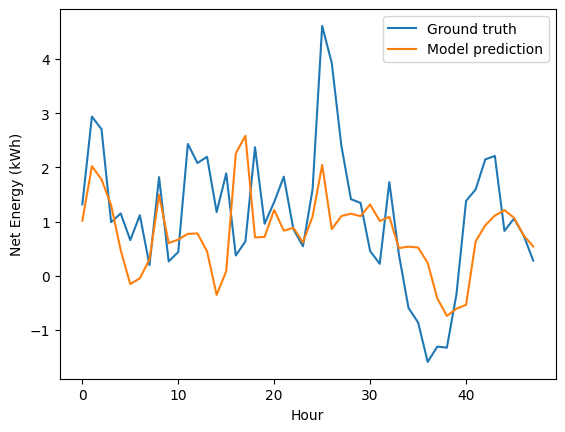

In [50]:
subset_Y = Y[:48]
plt.plot(np.arange(len(subset_Y)), subset_Y, '-', label="Ground truth")

preds = model.predict(X[:48])
plt.plot(np.arange(len(preds)), preds, '-', label="Model prediction")
plt.xlabel("Hour")
plt.ylabel("Net Energy (kWh)")
plt.legend()
plt.show()

# Electricity Consumption Dataset

In [57]:
with open("data/electricity_consumption_2020-2021.pkl", 'rb') as f:
    electricity_con_data = pickle.load(f)

with open("data/central_coast_hunter_weather.pkl", 'rb') as f:
    weather_data = pickle.load(f)

In [58]:
def get_customer_data(lga=0, customer=0):
    idx = np.arange(30, len(electricity_con_data[lga][customer]))
    expanded_idx = np.array([np.arange(i - 30, i - 1) for i in idx])
    return np.concatenate((electricity_con_data[lga][customer, expanded_idx].reshape(-1, 29, 1), weather_data[str(lga)][expanded_idx]), axis=-1), electricity_con_data[lga][customer, idx]

In [59]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((29, 8))
    # x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Conv1D(64, 5, activation="relu")(inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(32, 2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="mean_squared_error",
        metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [60]:
X, Y = get_customer_data()

In [61]:
model = create_model()
model.fit(X, Y, epochs=10)

Epoch 1/10
11/11 [==============================] - 0s 2ms/step - loss: 641016.3750 - mean_absolute_error: 302.2410 - root_mean_squared_error: 800.6350
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 523.1241 - mean_absolute_error: 16.5749 - root_mean_squared_error: 22.8719
Epoch 3/10
11/11 [==============================] - 0s 2ms/step - loss: 55.0029 - mean_absolute_error: 5.9207 - root_mean_squared_error: 7.4164
Epoch 4/10
11/11 [==============================] - 0s 2ms/step - loss: 27.8753 - mean_absolute_error: 4.2561 - root_mean_squared_error: 5.2797
Epoch 5/10
11/11 [==============================] - 0s 2ms/step - loss: 27.4987 - mean_absolute_error: 4.1738 - root_mean_squared_error: 5.2439
Epoch 6/10
11/11 [==============================] - 0s 2ms/step - loss: 29.8582 - mean_absolute_error: 4.3338 - root_mean_squared_error: 5.4643
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 24.3092 - mean_absolute_error: 3.9646 - root_mean_squ

11/11 [==============================] - 0s 672us/step


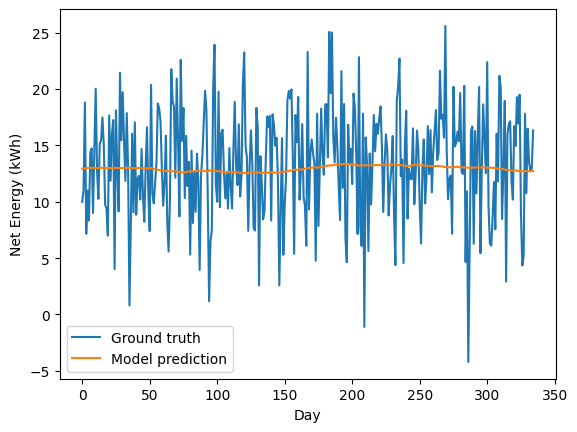

In [62]:
plt.plot(np.arange(len(Y)), Y, '-', label="Ground truth")

preds = model.predict(X)
plt.plot(np.arange(len(preds)), preds, '-', label="Model prediction")
plt.xlabel("Day")
plt.ylabel("Net Energy (kWh)")
plt.legend()
plt.show()